In [50]:
import pandas as pd
import numpy as np
import warnings
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# metrics and pipelines
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn import tree
from sklearn.pipeline import make_pipeline


import imblearn
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


In [51]:
# read data
fraud_df = pd.read_csv("fraud_analyst_interview_exercise_-_v2.csv")
# fraud_df = fraud_df.dropna()
warnings.simplefilter('ignore')  # deal and fix later
fraud_df['adjusted_acc_created_at'] = pd.to_datetime(
    fraud_df['adjusted_acc_created_at'])
fraud_df['adjusted_pmt_created_at'] = pd.to_datetime(
    fraud_df['adjusted_pmt_created_at'])
fraud_df["time_diff"] = fraud_df['adjusted_acc_created_at'] - \
    fraud_df['adjusted_pmt_created_at']


# Feature Engineering

In [52]:
# create binary variable based on whether the account was created AFTER the payment occured
fraud_df["creation_after_payment_flg"] = [1 if x >= dt.timedelta(0) else 0 for x in fraud_df["time_diff"]]


In [53]:
#create binary variable based on whether phone is version 6 or 10
fraud_df["is_version_6_or_10_flg"] = [1 if (x == 6) or (
    x == 10) else 0 for x in fraud_df["version"]]


In [54]:
# create binary variable based on whether merchant account is 0 

In [55]:
# create binary variable based on whether phone number/email/phone number is the same
fraud_df["same_phone_flg"] = (fraud_df["hashed_consumer_phone"] == fraud_df["hashed_buyer_phone"])
fraud_df["same_email_flg"] = (fraud_df["hashed_consumer_email"] == fraud_df["hashed_buyer_email"])  # 51/69
fraud_df["same_domain_flg"] = (fraud_df["consumer_email_domain"] == fraud_df["buyer_email_domain"])


In [56]:
# fraud_df.dtypes
# fraud_df.columns

In [57]:
cleaned_df = fraud_df.drop(columns=['adjusted_pmt_created_at', 'hashed_consumer_id',
               'adjusted_acc_created_at', 'hashed_buyer_email',
               'buyer_email_domain', 'hashed_consumer_email', 'consumer_email_domain',
                       'hashed_buyer_phone', 'hashed_consumer_phone', 'hashed_zip', 'version', 'time_diff', 'hashed_ip',"payment_id"])
cleaned_df.head()

,fraud_flag,device,merchant_name,amount,consumer_phone_age,merchant_account_age,ltv,consumer_gender,consumer_age,creation_after_payment_flg,is_version_6_or_10_flg,same_phone_flg,same_email_flg,same_domain_flg
0,0.0,Android,Red Shop,47500,139,358,32500,NaN,65,0,1,True,True,True
1,0.0,Android,Red Shop,580,108,19,3800,Female,66,0,1,True,True,True
2,0.0,Android,Red Shop,680,112,0,0,Male,49,0,0,True,True,True
3,0.0,Android,Red Shop,680,197,0,0,NaN,57,0,0,True,True,True
4,0.0,iPhone OS,Blue Shop,125400,13,0,0,Male,21,0,0,True,True,True


In [58]:
# one-hot-label
cleaned_df =  pd.get_dummies(cleaned_df, columns=[
               "device", "consumer_gender", "merchant_name"])

In [59]:
cleaned_df.head()

,fraud_flag,amount,consumer_phone_age,merchant_account_age,ltv,consumer_age,creation_after_payment_flg,is_version_6_or_10_flg,same_phone_flg,same_email_flg,same_domain_flg,device_Android,device_Mac OS X,device_Windows NT,device_iPad; CPU OS,device_iPhone OS,consumer_gender_Female,consumer_gender_Male,merchant_name_Blue Shop,merchant_name_Red Shop
0,0.0,47500,139,358,32500,65,0,1,True,True,True,1,0,0,0,0,0,0,0,1
1,0.0,580,108,19,3800,66,0,1,True,True,True,1,0,0,0,0,1,0,0,1
2,0.0,680,112,0,0,49,0,0,True,True,True,1,0,0,0,0,0,1,0,1
3,0.0,680,197,0,0,57,0,0,True,True,True,1,0,0,0,0,0,0,0,1
4,0.0,125400,13,0,0,21,0,0,True,True,True,0,0,0,0,1,0,1,1,0


In [60]:
# fraud_df.loc[(fraud_df['adjusted_pmt_created_at'] >= '2021-04-26')& (fraud_df['adjusted_pmt_created_at'] <= '2021-04-28')]
train_df = cleaned_df.iloc[np.where(np.isnan(fraud_df.fraud_flag ) == False)]
test_df = cleaned_df.iloc[np.where(np.isnan(fraud_df.fraud_flag) == True)] # data to label
# test_df


In [61]:
train_df = train_df.dropna()

In [62]:
train_df.head()

,fraud_flag,amount,consumer_phone_age,merchant_account_age,ltv,consumer_age,creation_after_payment_flg,is_version_6_or_10_flg,same_phone_flg,same_email_flg,same_domain_flg,device_Android,device_Mac OS X,device_Windows NT,device_iPad; CPU OS,device_iPhone OS,consumer_gender_Female,consumer_gender_Male,merchant_name_Blue Shop,merchant_name_Red Shop
0,0.0,47500,139,358,32500,65,0,1,True,True,True,1,0,0,0,0,0,0,0,1
1,0.0,580,108,19,3800,66,0,1,True,True,True,1,0,0,0,0,1,0,0,1
2,0.0,680,112,0,0,49,0,0,True,True,True,1,0,0,0,0,0,1,0,1
3,0.0,680,197,0,0,57,0,0,True,True,True,1,0,0,0,0,0,0,0,1
4,0.0,125400,13,0,0,21,0,0,True,True,True,0,0,0,0,1,0,1,1,0


In [63]:
train_Y = train_df.iloc[:,0]
train_X = train_df.iloc[:,1:]


In [64]:
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.3, random_state=42)


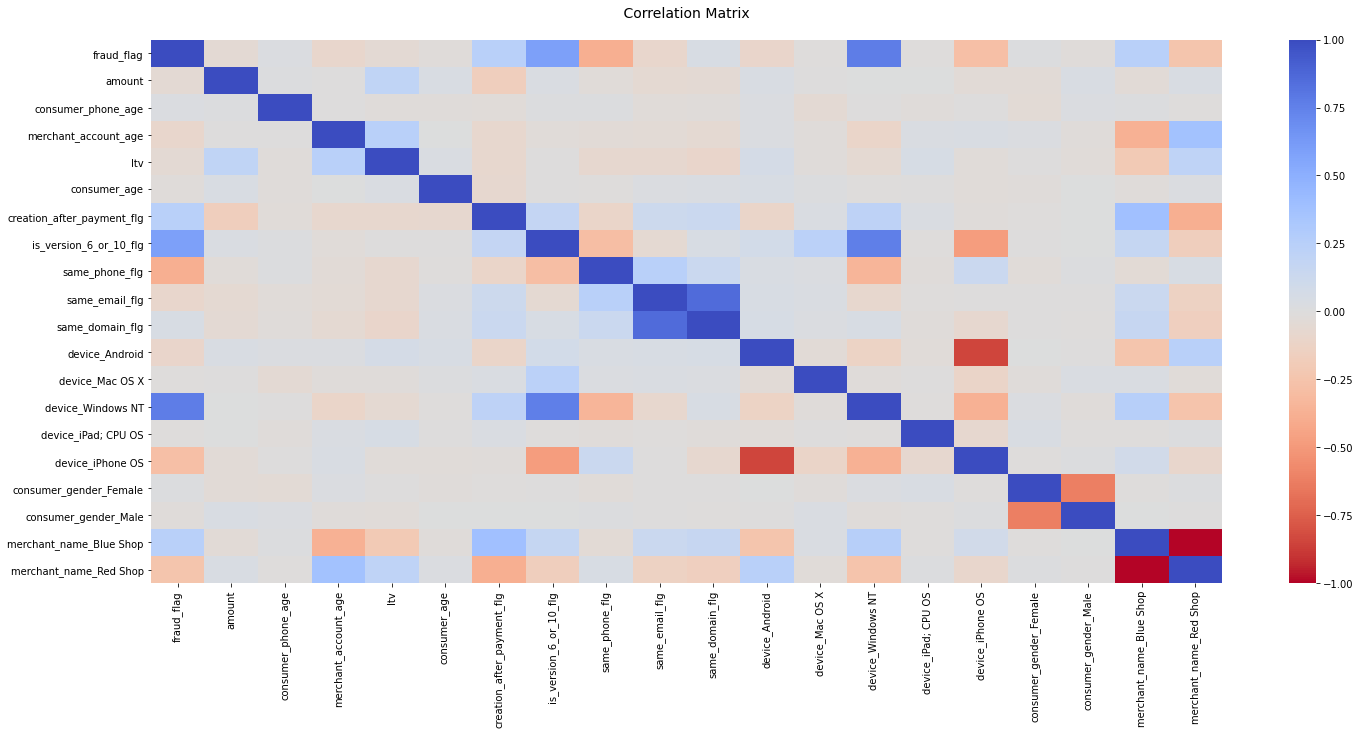

In [65]:
f, ax = plt.subplots(1, 1, figsize=(24, 10))

# Entire DataFrame
corr = train_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size': 20}, ax=ax)
ax.set_title(
    " Correlation Matrix \n", fontsize=14)
plt.show()


# Random oversampling

In [66]:

oversample = imblearn.over_sampling.RandomOverSampler(
    sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)



In [67]:
X_over.head()

,amount,consumer_phone_age,merchant_account_age,ltv,consumer_age,creation_after_payment_flg,is_version_6_or_10_flg,same_phone_flg,same_email_flg,same_domain_flg,device_Android,device_Mac OS X,device_Windows NT,device_iPad; CPU OS,device_iPhone OS,consumer_gender_Female,consumer_gender_Male,merchant_name_Blue Shop,merchant_name_Red Shop
0,12000,131,724,1100,64,1,0,True,True,True,0,0,0,0,1,0,0,0,1
1,9999,96,276,1800,54,0,0,True,True,True,1,0,0,0,0,0,0,0,1
2,26300,69,0,0,67,0,0,True,True,True,0,0,0,0,1,0,1,1,0
3,7500,20,582,850,70,0,0,False,True,True,0,0,0,0,1,1,0,0,1
4,14250,186,108,22500,66,0,0,True,True,True,0,0,0,0,1,1,0,0,1


In [68]:
sum(y_over)/len(y_over)

0.5

In [69]:
# common models
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}


In [70]:



for key, classifier in classifiers.items():
    classifier.fit(X_over, y_over)
    training_score = cross_val_score(classifier, X_over, y_over, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of",
          round(training_score.mean(), 2) * 100, "% accuracy score")


Classifiers:  LogisticRegression Has a training score of 99.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 98.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 100.0 % accuracy score


In [71]:
# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_over, y_over)
# get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_



In [72]:
knears_params = {"n_neighbors": list(range(2, 5, 1)), 'algorithm': [
    'auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_over, y_over)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_




In [73]:
# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2, 4, 1)),
               "min_samples_leaf": list(range(5, 7, 1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_over, y_over)

# tree best estimator
tree_clf = grid_tree.best_estimator_


In [74]:
log_reg_score = cross_val_score(log_reg,X_valid, y_valid, cv=5)
print('Logistic Regression Cross Validation Score: ', round(
    log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_valid, y_valid, cv=5)
print('Knears Neighbors Cross Validation Score', round(
    knears_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_valid, y_valid, cv=5)
print('DecisionTree Classifier Cross Validation Score',
      round(tree_score.mean() * 100, 2).astype(str) + '%')


Logistic Regression Cross Validation Score:  98.78%
Knears Neighbors Cross Validation Score 98.18%
DecisionTree Classifier Cross Validation Score 99.39%


In [75]:
log_pred = log_reg.predict(X_valid)
knearest_pred = knears_neighbors.predict(X_valid)
tree_pred = tree_clf.predict(X_valid)

In [76]:
labels = ["Fraud", "No Fraud"]
print(classification_report(y_valid,log_pred, target_names=labels))


              precision    recall  f1-score   support

       Fraud       1.00      0.89      0.94       640
    No Fraud       0.21      1.00      0.34        18

    accuracy                           0.90       658
   macro avg       0.60      0.95      0.64       658
weighted avg       0.98      0.90      0.93       658



In [77]:
print(classification_report(y_valid, knearest_pred, target_names=labels))


              precision    recall  f1-score   support

       Fraud       0.99      0.99      0.99       640
    No Fraud       0.55      0.61      0.58        18

    accuracy                           0.98       658
   macro avg       0.77      0.80      0.78       658
weighted avg       0.98      0.98      0.98       658



In [78]:
print(classification_report(y_valid, tree_pred, target_names=labels))


              precision    recall  f1-score   support

       Fraud       1.00      1.00      1.00       640
    No Fraud       0.86      1.00      0.92        18

    accuracy                           1.00       658
   macro avg       0.93      1.00      0.96       658
weighted avg       1.00      1.00      1.00       658



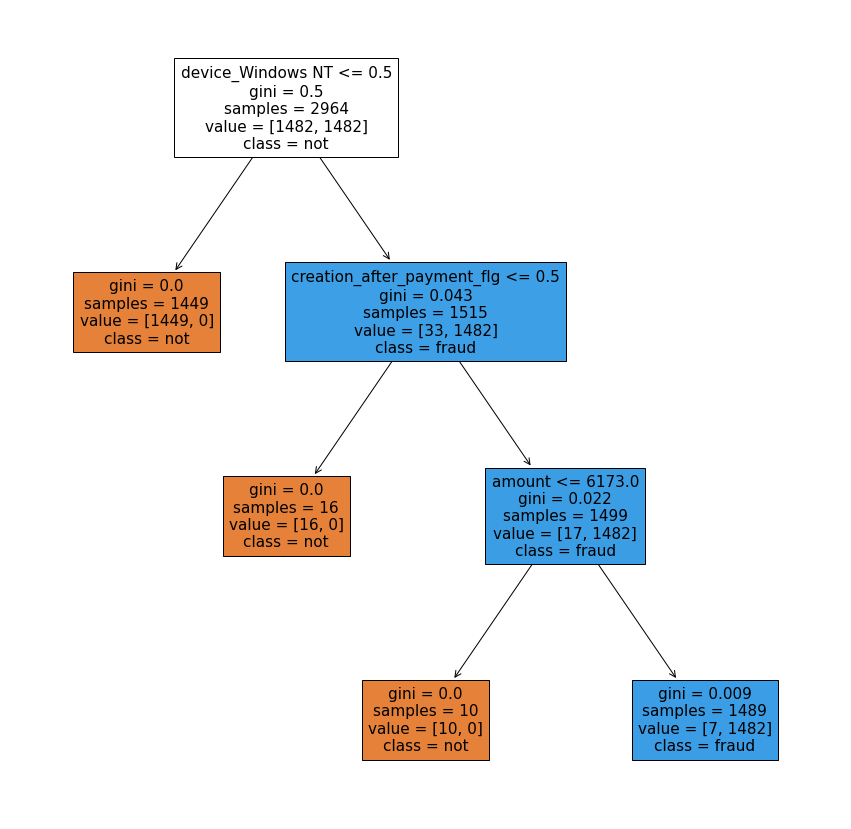

In [79]:

fig = plt.figure(figsize=(15, 15))
_ = tree.plot_tree(tree_clf,
                   feature_names=X_over.columns,
                   class_names=["not", "fraud"],
                   filled=True)


# actual labeling the unflagged data

In [80]:
# t_Y = test_df.iloc[:,0]
test_X = test_df.iloc[:,1:]


In [84]:
test_df["log_pred"] = log_reg.predict(test_X)
test_df["knearest_pred"] = knears_neighbors.predict(test_X)
test_df["tree_pred"] = tree_clf.predict(test_X)


(array([9561.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1487.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

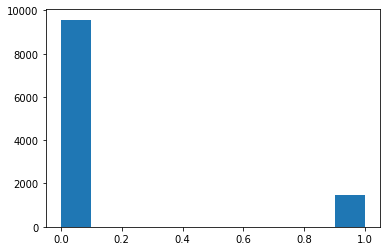

In [85]:
plt.hist(test_df["log_pred"])
